In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as opt

In [2]:
class Node:
    def __init__(self,branches=None,attribute=None,threshold=None,value=None):
        if branches is None and value is None:
            print("ERROR")
        
        self.branches = branches
        self.threshold = threshold
        self.attribute = attribute
        self.is_leaf = False if value is None else True
        self.value = value
        
    def get_child(self,df):
        if isinstance(df[self.attribute],(int,float)):
            return self.branches[0] if df[self.attribute] < self.threshold else self.branches[1]
        else:
            return self.branches[0] if df[self.attribute] in self.threshold else self.branches[1]
        
    def make_leaf(self,value):
        pass
    
    def restore_branches(self):
        pass
        

In [3]:
class Tree:
    def __init__(self,root):
        self.root = root
        
    def predict(self,x):
        item = self.root
        while not item.is_leaf:
            item = item.get_child(x)
        return item
    
    def leaf_count(self):
        return self._lcount(self.root)
    
    def _lcount(self,node):
        if node.is_leaf:
            return 1
        else:
            return self._lcount(node.branches[0]) + self._lcount(node.branches[1])

In [4]:
l0= Node(value="young")
l1=Node(value="old")
r=Node([l0,l1],"age",18)
t=Tree(r)
print(t.predict({"age":2}).value)

young


In [5]:
print(t.predict({"age":20}).value)

old


In [6]:
t.leaf_count()

2

In [7]:
class CART:
    def __init__(self,df,y_name,X_names):
        self.df = df
        self.y_name = y_name
        self.X_names = X_names
        self.tree = None
        self.splittyness = 1.
        self.leaf_loss_threshold = 1e-12
        
        self.classes = np.unique(df[self.y_name]).tolist()
        n = len(self.classes)
        self.confusion_matrix = np.zeros((n,n))
        
    def create_tree(self,splittyness=1., leaf_loss_threshold=1e-12):
        self.splittyness = splittyness
        self.leaf_loss_threshold = leaf_loss_threshold
        root = self._node_or_leaf(self.df)
        self.tree = Tree(root)
        return self.tree
    
    def _gini_impurity(self, df):
        unique, counts = np.unique(df[self.y_name].values, return_counts=True)
        N = df[self.y_name].values.ravel().size
        p = counts/N
        #print(unique)
        #print(p)
        return 1. - np.sum(p**2)
    
    def _shannon_entropy(self,df):
        unique, counts = np.unique(df[self.y_name].values, return_counts=True)
        N = df[self.y_name].values.size
        p = counts/N
        return -np.sum(p * np.log2(p))
        
    def _opt_fun(self,df,split_name):
        def fun(x):
            split_df = [df[df[split_name]<x],
                        df[df[split_name]>=x]]
            return self._loss(split_df[0]) + self._loss(split_df[1])
        return fun
        
    def _node_or_leaf(self,df):
        loss_parent = self._loss(df)
        if loss_parent < self.leaf_loss_threshold:
            return self._leaf(df)
        
        loss_best, split_df, split_threshold, split_name = self._loss_best(df)
        print(f"Computed split:\nloss: {loss_best:.2f} (parent: {loss_parent:.2f})\nattribute: {split_name}\nthreshold: {split_threshold}\ncount: {[len(df_.index) for df_ in split_df]}")
        if loss_best * self.splittyness < loss_parent:
            print(f"  => creating Node({split_name}, {split_threshold})\n")
            branches = []
            for i in range(2):
                branches.append(self._node_or_leaf(split_df[i]))
            item = Node(branches=branches,attribute=split_name,threshold=split_threshold)
        else:
            item = self._leaf(df)
        return item
    
    def _leaf(self,df):
        unique, counts = np.unique(df[self.y_name].values,return_counts=True)
        print([(unique[i], counts[i]) for i in range(len(counts))])
        sort_ind = np.argsort(-counts)
        value = unique[sort_ind[0]]
        leaf = Node(value=value)
        
        # confusion matrix
        i_predict = self.classes.index(value)
        for i, c in enumerate(unique):
            i_c = self.classes.index(c)
            self.confusion_matrix[i_c,i_predict] += counts[i]
        
        print(f"  => creating Leaf({value}, N={len(df.index)})\n")
        return leaf
    
    def _loss_best(self,df):
        loss0 = 10
        for name in self.X_names:
            if np.issubdtype(df[name].values.dtype, np.number):
                #split_threshold_ = np.median(df[name].v
                res = opt.minimize_scalar(self._opt_fun(df,name),bounds=(df[name].min(),df[name].max()),method="bounded")
                split_threshold_ = res.x
                split_df_ = [df[df[name]<split_threshold_],
                        df[df[name]>=split_threshold_]]
                #loss = self._loss(split_df_[0]) + self._loss(split_df_[1])
                loss = res.fun
            else:
                unique = np.unique(df[name])
                split_threshold_ = [unique.ravel()[0]]
                split_df_ =[df[df[name].isin(split_threshold_)],
                            df[~df[name].isin(split_threshold_)]]
                loss = self._loss(split_df_[0]) + self._loss(split_df_[1])
            if loss < loss0:
                loss0 = loss
                split_threshold = split_threshold_
                split_df = split_df_
                split_name = name
                
        #print(loss0)
                
        return loss0, split_df, split_threshold, split_name
    
    def _loss(self,df):
        #return self._gini_impurity(df)
        return self._shannon_entropy(df)
    
    def metrics(self):
        P = self._precision(self.confusion_matrix)
        print(f"precision: {P}")
        R = self._recall(self.confusion_matrix)
        print(f"recall: {R}")
        F = np.mean(self._F1(P,R))
        print(f"F-score: {F}")
        return {"precision":P,
                "recall":R,
                "F-score":F}
    
    def _miss(self,df):
        N = len(df.index)
        miss = 0
        unique, counts = np.unique(df[self.y_name], return_counts=True)
        p = counts/N
        d = {}
        for i, c in enumerate(unique):
            d[c] = p[i]
        for i in range(N):
            x = df.iloc[i]
            pred = self.tree.predict(x).value
            if pred != x[self.y_name]:
                miss += 1 * d[pred]
        return miss/N
    
    def _k_fold_miss(self,k=5,frac=0.5):
        R = []
        for i in range(k):
            df = self.df.sample(frac=frac, replace=True)
            r = self._miss(df)
            R.append(r)
        return R
    
    def missclassification_cost(self,k=5,frac=0.5):
        R = self._k_fold_miss(k=k,frac=frac)
        alpha = 0.01
        n_leafs = self.tree.leaf_count()
        return np.mean(R) + alpha * n_leafs
    
    def prune(self):
        R0 = self.misclassification_cost()
        node=self.tree.root
        pass
    
    def _p(self,node):
        node.is_leaf = True
        
        R = self.missclassification_cost()
        
        
    
    @staticmethod
    def _precision(m):
        return np.diag(m) / np.sum(m, axis=1)
        
    
    @staticmethod
    def _recall(m):
        return np.diag(m) / np.sum(m, axis=0)
    
    @staticmethod
    def _F1(P,R):
        #F = np.zeros_like(P)
        #for i in range(len(
        return 2 * P * R / (P + R)
            
        
        

In [8]:
df=pd.read_csv("iris.csv")

In [9]:
df.columns
X_names=["petal_length","petal_width"]
df[X_names]

,petal_length,petal_width
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2
...,...,...
145,5.2,2.3
146,5.0,1.9
147,5.2,2.0
148,5.4,2.3


In [10]:
df.iloc[0]

sepal_length       5.1
sepal_width        3.5
petal_length       1.4
petal_width        0.2
species         setosa
Name: 0, dtype: object

In [11]:
c = CART(df,"species",X_names)
c.create_tree(splittyness=1.)

Computed split:
loss: 1.00 (parent: 1.58)
attribute: petal_length
threshold: 2.1710255770469358
count: [50, 100]
  => creating Node(petal_length, 2.1710255770469358)

[('setosa', 50)]
  => creating Leaf(setosa, N=50)

Computed split:
loss: 0.60 (parent: 1.00)
attribute: petal_width
threshold: 1.7214693014514397
count: [54, 46]
  => creating Node(petal_width, 1.7214693014514397)

Computed split:
loss: 0.46 (parent: 0.45)
attribute: petal_length
threshold: 3.3187148423012083
count: [3, 51]
[('versicolor', 49), ('virginica', 5)]
  => creating Leaf(versicolor, N=54)

Computed split:
loss: 0.16 (parent: 0.15)
attribute: petal_length
threshold: 6.404263506154478
count: [42, 4]
[('versicolor', 1), ('virginica', 45)]
  => creating Leaf(virginica, N=46)



In [12]:
c.tree.predict(df.iloc[0]).value

'setosa'

In [13]:
c._k_fold_miss()
c.missclassification_cost()

0.04408

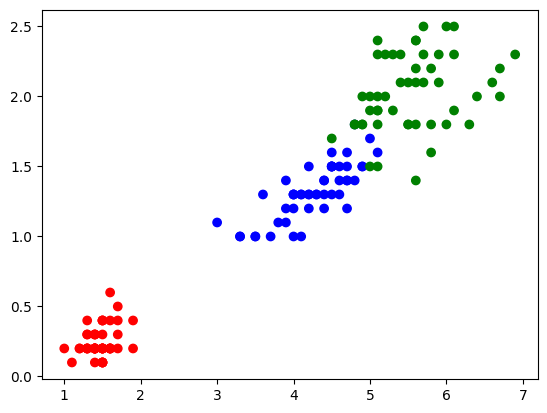

In [14]:
import matplotlib.pyplot as plt
colors = {"setosa":"red", "versicolor":"blue", "virginica":"green"}
plt.scatter(df["petal_length"],df["petal_width"],c=df["species"].map(colors))


In [15]:

x, y = np.meshgrid(np.linspace(1,7,11),np.linspace(0,2.5,11))
col = []
for i in range(len(x.ravel())):
    d = df.iloc[120].copy()
    d["petal_length"] = x.ravel()[i]
    d["petal_width"] = y.ravel()[i]
    col.append(c.tree.predict(d).value)
for i in range(len(col)):
    if col[i] == "setosa":
        col[i] = 0
    if col[i] == "versicolor":
        col[i] = 1
    if col[i] == "virginica":
        col[i] = 2
z = np.array(col).reshape(x.shape)

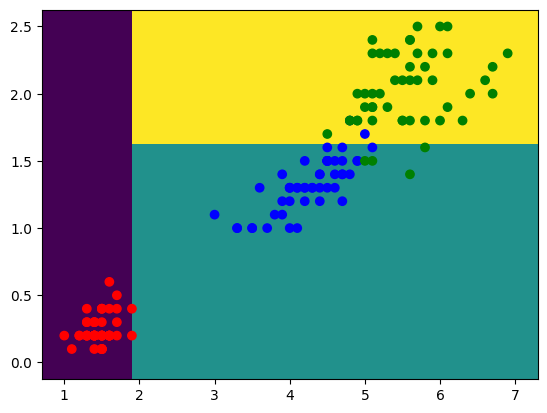

In [16]:
fig, ax = plt.subplots()
ax.pcolormesh(x,y,z)
ax.scatter(df["petal_length"],df["petal_width"],c=df["species"].map(colors))

In [17]:
c.confusion_matrix
c.metrics()

precision: [1.   0.98 0.9 ]
recall: [1.         0.90740741 0.97826087]
F-score: 0.9599358974358975


{'precision': array([1.  , 0.98, 0.9 ]),
 'recall': array([1.        , 0.90740741, 0.97826087]),
 'F-score': 0.9599358974358975}

In [18]:
titanic = pd.read_csv("titanic.csv")
titanic

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


In [19]:
titanic.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Siblings/Spouses Aboard',
       'Parents/Children Aboard', 'Fare'],
      dtype='object')

In [20]:

c_titanic = CART(titanic,"Survived",["Pclass","Age","Fare","Siblings/Spouses Aboard","Sex","Parents/Children Aboard"])
c_titanic.create_tree(splittyness=0.95)

Computed split:
loss: 0.96 (parent: 0.96)
attribute: Fare
threshold: 316.6368710873478
count: [884, 3]
  => creating Node(Fare, 316.6368710873478)

Computed split:
loss: 0.96 (parent: 0.96)
attribute: Siblings/Spouses Aboard
threshold: 5.535563618544633
count: [877, 7]
  => creating Node(Siblings/Spouses Aboard, 5.535563618544633)

Computed split:
loss: 1.43 (parent: 0.96)
attribute: Age
threshold: 65.64855785290877
count: [867, 10]
[(0, 538), (1, 339)]
  => creating Leaf(0, N=877)

[(0, 7)]
  => creating Leaf(0, N=7)

[(1, 3)]
  => creating Leaf(1, N=3)



In [21]:

c_titanic.metrics()

precision: [1.         0.00877193]
recall: [0.61651584 1.        ]
F-score: 0.39008123649861565


{'precision': array([1.        , 0.00877193]),
 'recall': array([0.61651584, 1.        ]),
 'F-score': 0.39008123649861565}

In [22]:

penguins = pd.read_csv("penguins.txt").dropna()
penguins.columns

Index(['rowid', 'species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year'],
      dtype='object')

In [23]:
penguins

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,6,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...,...
339,340,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,341,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,342,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,343,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [24]:
c_penguins = CART(penguins,"species",["island","bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g","sex"])

In [25]:
c_penguins.create_tree()

Computed split:
loss: 1.36 (parent: 1.52)
attribute: flipper_length_mm
threshold: 210.5221483679152
count: [237, 96]
  => creating Node(flipper_length_mm, 210.5221483679152)

Computed split:
loss: 0.94 (parent: 1.28)
attribute: bill_depth_mm
threshold: 15.312156278526421
count: [23, 214]
  => creating Node(bill_depth_mm, 15.312156278526421)

[('Gentoo', 23)]
  => creating Leaf(Gentoo, N=23)

Computed split:
loss: 0.58 (parent: 0.94)
attribute: bill_length_mm
threshold: 46.05408467530133
count: [161, 53]
  => creating Node(bill_length_mm, 46.05408467530133)

Computed split:
loss: 0.45 (parent: 0.45)
attribute: bill_length_mm
threshold: 32.576775870153554
count: [1, 160]
[('Adelie', 146), ('Chinstrap', 15)]
  => creating Leaf(Adelie, N=161)

Computed split:
loss: -0.00 (parent: 0.14)
attribute: island
threshold: ['Biscoe']
count: [1, 52]
  => creating Node(island, ['Biscoe'])

[('Gentoo', 1)]
  => creating Leaf(Gentoo, N=1)

[('Chinstrap', 52)]
  => creating Leaf(Chinstrap, N=52)

Comput

In [26]:
c_penguins.metrics()

precision: [1.         0.77941176 1.        ]
recall: [0.9068323 1.        1.       ]
F-score: 0.9423910409992732


{'precision': array([1.        , 0.77941176, 1.        ]),
 'recall': array([0.9068323, 1.       , 1.       ]),
 'F-score': 0.9423910409992732}